<a href="https://colab.research.google.com/github/KayalvizhiT513/C4.5-Algorithm/blob/main/C4_5_tree_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import math
import pandas as pd
from math import log2
import numpy as np
import copy
from scipy.optimize import minimize_scalar
from scipy.stats import binom

In [2]:
class TreeNode:
    def __init__(self, label=None, attribute=None, branches=None):
        self.label = label
        self.attribute = attribute
        self.branches = branches or {}

    def get_label(self):
        if self.label is not None:
            return str(self.label)
        elif self.attribute is not None:
            return str(self.attribute)
        else:
            return ""

    def is_leaf(self):
        return not bool(self.branches)

    def add_to_dot(self, dot):
        node_id = str(id(self))
        label = str(self.get_label())  # Ensure label is a string

        if self.is_leaf():
            # Set shape to rectangle for leaf nodes
            dot.node(node_id, label=label, shape='rectangle')
        else:
            dot.node(node_id, label=label)

        for branch_label, branch in self.branches.items():
            branch.add_to_dot(dot)
            dot.edge(node_id, str(id(branch)), label=str(branch_label))  # Ensure branch label is a string



In [3]:
def c45(examples, target_attribute, attributes, validation_data=None, root=None):
    root = TreeNode()

    # If all examples are positive, return a single-node tree with label = 'Play'
    if all(example[target_attribute] == 'Pass' for example in examples if example['weight'] == 1 or example['weight'] == 0):
        weight_sum = sum(example['weight'] for example in examples)
        error_sum = sum(example['weight'] for example in examples if not (example[target_attribute] == 'Pass'))
        root.label = f'Pass ({weight_sum:.1f}/{error_sum:.1f})'

    # If all examples are negative, return a single-node tree with label = "Don't Play"
    elif all(example[target_attribute] == 'Fail' for example in examples if example['weight'] == 1 or example['weight'] == 0):
        weight_sum = sum(example['weight'] for example in examples)
        error_sum = sum(example['weight'] for example in examples if not (example[target_attribute] == 'Fail'))
        root.label = f'Fail ({weight_sum:.1f}/{error_sum:.1f})'

    # If attributes is empty, return a single-node tree with label = most common value of Targetattribute
    elif not attributes:
        root.label = most_common_value(examples, target_attribute)

    else:
        # Choose the best attribute to split on
        best_attribute, threshold = choose_best_attribute(examples, target_attribute, attributes)

        examples_with_nan = [example for example in examples if pd.isna(example.get(best_attribute))]
        examples_not_nan = [example for example in examples if not pd.isna(example.get(best_attribute))]
        len_of_not_null = len(examples_not_nan)

        for example in examples_not_nan:
            if example['weight'] == 0:
                example['weight'] = 1
            else:
                example['weight'] *= 1

        # Split the examples based on the chosen attribute
        subsets = {}
        if attribute_type_mapping[best_attribute] == 0:
            root.attribute = best_attribute
            attribute_values = attributes_dict[best_attribute]
            for value in attribute_values:
                subsets[value] = [example for example in examples_not_nan if example[best_attribute] == value]
                len_of_attr_val = sum(1 for example in examples_not_nan if example[best_attribute] == value)
                if len_of_not_null != 0:
                    w = len_of_attr_val/len_of_not_null
                    ex_copy = copy.deepcopy(examples_with_nan)
                    for example in ex_copy:
                        example['weight'] = w

                    subsets[value].extend(ex_copy)
                else:
                    subsets[value] = [example for example in examples_with_nan if example[best_attribute] == value]
        else:
            subsets['yes'] = [example for example in examples if float(example[best_attribute]) <= threshold]
            subsets['no'] = [example for example in examples if float(example[best_attribute]) > threshold]
            best_attribute = f"{best_attribute} <= {threshold}"
            root.attribute = best_attribute
            attributes_dict[best_attribute] = ['yes', 'no']

        for value in subsets:
            if not subsets[value]:
                # If subset is empty, add a leaf node with label = most common value of Targetattribute
                leaf = TreeNode(label=most_common_value(examples, target_attribute))
                root.branches[value] = leaf
            else:
                # Recursively add subtree
                subtree = c45(subsets[value], target_attribute, [attr for attr in attributes if attr != best_attribute])
                root.branches[value] = subtree

    return root


In [4]:
def most_common_value(examples, target_attribute):
    # Return the most common value of the target attribute in the given examples
    positive_count = sum(1 for example in examples if example[target_attribute] == 'Pass')
    negative_count = sum(1 for example in examples if example[target_attribute] == "Fail")
    return 'Pass' if positive_count >= negative_count else "Fail"


In [5]:
# Function to compute entropy of a set
def compute_entropy(labels):
    unique_labels = labels.unique()
    entropy = 0.0

    for label in unique_labels:
        prob = (labels == label).sum() / len(labels)
        entropy -= prob * log2(prob)

    return entropy

# Function to compute entropy of a split
def compute_split_entropy(left_labels, right_labels, target_column):
    total_length = len(left_labels) + len(right_labels)
    left_weight = len(left_labels) / total_length
    right_weight = len(right_labels) / total_length

    left_entropy = compute_entropy(left_labels[target_column])
    right_entropy = compute_entropy(right_labels[target_column])

    split_entropy = left_weight * left_entropy + right_weight * right_entropy
    return split_entropy

# Function to compute split information for gain ratio
def compute_split_info(left_subset, right_subset, continuous_attribute):
    total_length = len(left_subset) + len(right_subset)
    left_weight = len(left_subset) / total_length
    right_weight = len(right_subset) / total_length

    left_values = left_subset[continuous_attribute].unique()
    right_values = right_subset[continuous_attribute].unique()

    left_info = -sum((len(left_subset[left_subset[continuous_attribute] == value]) / len(left_subset)) * log2(len(left_subset[left_subset[continuous_attribute] == value]) / len(left_subset)) for value in left_values if len(left_subset[left_subset[continuous_attribute] == value]) > 0)

    right_info = -sum((len(right_subset[right_subset[continuous_attribute] == value]) / len(right_subset)) * log2(len(right_subset[right_subset[continuous_attribute] == value]) / len(right_subset)) for value in right_values if len(right_subset[right_subset[continuous_attribute] == value]) > 0)

    split_info = left_weight * left_info + right_weight * right_info
    return split_info



In [15]:
def compute_categorical_gain_ratio(subset, target_column, attribute):
    subset = pd.DataFrame(subset)
    initial_entropy = compute_entropy(subset[target_column])

    # Extract unique values of the 'attribute' from a subset, remove occurrences of 'nan', and calculates the fraction (F) of non-'nan' values
    attribute_values = subset[attribute].unique()
    attribute_values_without_nan = attribute_values[pd.notna(attribute_values)]
    F = len(attribute_values_without_nan)/len(attribute_values)

    weighted_entropy = 0.0
    split_info = 0.0

    for value in attribute_values_without_nan:
        if pd.isna(value):
            value_subset = subset[pd.isna(subset[attribute])]
        else:
            value_subset = subset[subset[attribute] == value]
        value_weight = len(value_subset) / len(subset)

        value_entropy = compute_entropy(value_subset[target_column])
        weighted_entropy += value_weight * value_entropy

        split_info -= value_weight * log2(value_weight)

    gain = F*(initial_entropy - weighted_entropy)
    gain_ratio = gain / split_info if split_info != 0 else 0.0

    return gain_ratio


def calculate_continuous_gain_ratio(examples, target_attribute, attribute):

    # Specify the continuous attribute and the target column
    continuous_attribute = attribute
    target_column = target_attribute

    df = pd.DataFrame(examples)

    # Sort the DataFrame based on the continuous attribute
    df_sorted = df.sort_values(by=continuous_attribute)

    # Compute initial entropy before the split
    initial_entropy = compute_entropy(df_sorted[target_column])

    # Initialize variables to keep track of best split
    best_gain_ratio = 0.0
    best_threshold = None

    # Iterate through possible split points
    for i in range(1, len(df_sorted)):
        #if df_sorted.iloc[i - 1][continuous_attribute] == df_sorted.iloc[i][continuous_attribute]:
        #    continue
        threshold = (float(df_sorted.iloc[i - 1][continuous_attribute]) + float(df_sorted.iloc[i][continuous_attribute])) / 2.0

        # Split the data into two subsets based on the threshold
        left_subset = df_sorted[df_sorted[continuous_attribute] <= threshold]
        right_subset = df_sorted[df_sorted[continuous_attribute] > threshold]

        # Calculate gain and split information for the current split
        gain = initial_entropy - compute_split_entropy(left_subset, right_subset, target_column)
        split_info = compute_split_info(left_subset, right_subset, continuous_attribute)

        # Calculate gain ratio
        gain_ratio = gain / split_info if split_info != 0 else 0.0

        # Update best split if gain ratio is higher
        if gain_ratio > best_gain_ratio:
            best_gain_ratio = gain_ratio
            best_threshold = threshold

    # Return the maximum gain ratio
    return best_gain_ratio, best_threshold



In [7]:
def choose_best_attribute(examples, target_attribute, attributes):
    best_attribute = None
    best_gain_ratio = -1
    threshold = -1
    gain_threshold_list = {}

    for attribute in attributes:
        # Check if the attribute is continuous
        if attribute_type_mapping[attribute] == 1:
            gain_ratio, threshold = calculate_continuous_gain_ratio(examples, target_attribute, attribute)
            gain_threshold_list[gain_ratio] = threshold

        else:
            gain_ratio = compute_categorical_gain_ratio(examples, target_attribute, attribute)
            gain_threshold_list[gain_ratio] = threshold

        if gain_ratio > best_gain_ratio:
            best_gain_ratio = gain_ratio
            best_attribute = attribute

    return best_attribute, gain_threshold_list[best_gain_ratio]


In [8]:
def print_tree(node, indent=0):
    if node.label is not None:
        print("  " * indent + f"Decision: {node.label}")
    else:
        print("  " * indent + f"Attribute: {node.attribute}")
        for value, subtree in node.branches.items():
            print("  " * (indent + 1) + f"Value: {value}")
            print_tree(subtree, indent + 2)


In [9]:
def print_leaf(node):
    leaves = []  # Use a Python list, not a NumPy array

    if node.label is not None:
        return [node.label]  # Return a list with the label

    for value, subtree in node.branches.items():
        leaves.extend(print_leaf(subtree))  # Use extend instead of append

    return leaves

Attribute: B <= 10.0
  Value: yes
    Attribute: A <= 20.0
      Value: yes
        Decision: Fail (31.0/0.0)
      Value: no
        Decision: Pass (17.0/0.0)
  Value: no
    Decision: Pass (52.0/0.0)


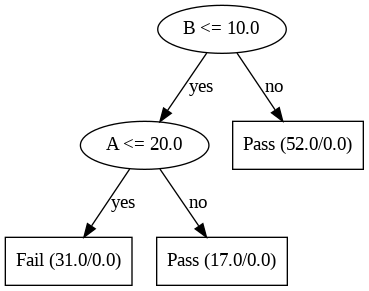

In [16]:
# Load data from Excel file
file_path = '/content/Book5.xlsx'
df = pd.read_excel(file_path)

# Example attributes and target_attribute
attributes = df.columns[:-1].tolist()
target_attribute = df.columns[-1]

# Adding a column named "weight" with default values of 0
df['weight'] = 0

# Create a dictionary with unique attribute values
attributes_dict = {col: df[col].dropna().unique().tolist() for col in df.columns}

# Initialize the attribute type mapping dictionary
attribute_type_mapping = {}

# Iterate over columns and classify attributes
for attribute in df.columns:
    # Check if an attribute is categorical or continuous
    is_float = pd.to_numeric(df[attribute], errors='coerce').notnull().all()
    num_unique_values = df[attribute].nunique()

    if is_float and num_unique_values > 2:
        attribute_type_mapping[attribute] = 1  # Continuous
    else:
        attribute_type_mapping[attribute] = 0  # Categorical

# Example usage
tree = c45(df.to_dict(orient='records'), target_attribute, attributes)
print_tree(tree)

# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
tree.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename='tree1', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import Image
Image(filename='tree1.png')

In [11]:
def predicted_error_rate(n_value, k_value):# Function representing the cumulative binomial distribution equation
    def cumulative_binomial_eq(p, k, n):
        return abs(binom.cdf(k, n, p) - 0.25)

    # Solve for p using minimize_scalar with bounds
    result = minimize_scalar(cumulative_binomial_eq, bounds=(0, 1), args=(k_value, n_value), method='bounded')
    return result.x

def can_prune(node, new_leaf = None):
    leaf_labels = print_leaf(node)
    if 'Pass' not in leaf_labels[0]:
        leaf_labels = leaf_labels[::-1]
    NE_list = []

    for each in leaf_labels:
        split_case = each.split()
        string_list = split_case[-1][1:-1].split('/')
        float_list = [float(element) for element in string_list]
        NE_list.append(float_list)

    predicted_error_before_pruning = NE_list[0][0] * predicted_error_rate(NE_list[0][0], NE_list[0][1]) + NE_list[1][0] * predicted_error_rate(NE_list[0][0], NE_list[1][1])
    predicted_error_after_pruning = (NE_list[0][0] + NE_list[1][0]) * predicted_error_rate((NE_list[0][0] + NE_list[1][1]), (NE_list[0][1] + NE_list[1][0]))

    E = NE_list[0][0] + NE_list[1][1]
    N = NE_list[0][1] + NE_list[1][0]

    if NE_list[0][0] >= NE_list[1][0]:
        new_leaf = f'Pass ({N}/{E})'
    else:
        new_leaf = f'Fail ({N}/{E})'
    print(predicted_error_before_pruning, predicted_error_after_pruning)
    return predicted_error_before_pruning >= predicted_error_after_pruning, new_leaf


In [12]:
def process_tree(node):
    if not node.is_leaf():
        processed_branches = {}
        for value, subtree in node.branches.items():
            processed_subtree = process_tree(subtree)
            processed_branches[value] = processed_subtree

        # Check your condition here
        if all(processed_subtree.is_leaf() for processed_subtree in processed_branches.values()):
            result = can_prune(node)
            if result[0]:  # Replace with your actual condition
                # If condition is true, make the current node a leaf
                leaf_label = result[1] # Replace with appropriate label
                return TreeNode(label=leaf_label)

        # If condition is not met or not applicable, keep the node unchanged
        return TreeNode(attribute=node.attribute, branches=processed_branches)

    # If the node is already a leaf, no further processing needed
    return node


3.7589005868116665 47.999713878672644


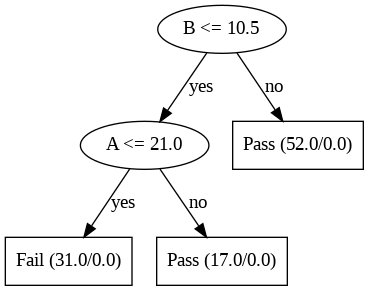

In [13]:
tree1 = process_tree(tree)

# Create a Digraph object
dot = Digraph(comment='Tree')

# Add nodes and edges to the Digraph
tree1.add_to_dot(dot)

# Render the tree in Colab
dot.render(filename='tree2', format='png', cleanup=True, engine='dot')

# Display the tree image in Colab
from IPython.display import Image
Image(filename='tree2.png')